<a href="https://colab.research.google.com/github/imtiaj-sreejon/Coursera_Capstone/blob/master/Capstone_Project_Notebook_for_IBM_Applied_Data_Science_Pro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <font size=14>Capstone Project Notebook</font>
This notebook is for the <font color='green'>**capstone project**</font> under <font color='teal'>*IBM Applied Data Science Professional Course*</font> hosted on Coursera.

In [76]:
import pandas as pd
import numpy as np

print('Hello Capstone Project Course!')

Hello Capstone Project Course!


# Build Toronto neighborhood dataframe by scraping [Wikipedia](https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M) 

### Our objective in this section is to get the postal code and neighborhood information from wikipedia and put that into a *pandas* dataframe.

At first, we need to fetch the wikipedia page through the <b><i>requests</i></b> module.

In [77]:
import requests

url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'

source = requests.get(url).text

# print first 6 lines
for i, line in zip(range(6), source.splitlines()):
    print(line)


<!DOCTYPE html>
<html class="client-nojs" lang="en" dir="ltr">
<head>
<meta charset="UTF-8"/>
<title>List of postal codes of Canada: M - Wikipedia</title>


Now let's import <b>BeautifulSoup</b> which is the most popular library for parsing webpage.

In [0]:
import bs4
from bs4 import BeautifulSoup

We will parse the wikipedia page now. As the postal codes of Toronto are recorded in a table, to avoid unneceassary memory wastage, we will parse only the portion of the webpage that contains `<table>` tags.  For more info on parsing part of a webpage, visit [here](https://beautiful-soup-4.readthedocs.io/en/latest/#parsing-only-part-of-a-document).

We will use the <b>lxml</b> parser as it supports parsing partial webpage.

In [0]:
from bs4 import SoupStrainer # this module is needed for partial parsing

only_table_tags = SoupStrainer('table')

soup = BeautifulSoup(source, 'lxml', parse_only=only_table_tags)

print(soup.prettify()) # the output is cleared to save space

# limit height of scrollable output window
from IPython.display import Javascript
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 400})'''))

Now we have got all the tables in the page and we can see, there are 3 tables in total. The first table contains our desired postal codes. So, if we use the `find()` method then it will return only the first matching occurence and thats what we need.

In [0]:
postal_code_table = soup.find('table')

print(postal_code_table.prettify()) # the output is cleared to save space

# limit height of scrollable output window
from IPython.display import Javascript
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 400})'''))

Here we can see, each neighborhood information is contained within a separate ***&lt;tr&gt;*** tag. Each `<tr>` tag contains 3 `<td>` tags. First `<td>` contains the **postal code**. Second one contains the **Borough**. And last one contains **Neighborhood** name. 

For making the task a bit easier, we will remove the first row as its just the header names. And we will store rest of the table in a separate variable.

In [81]:
# soup_object('string_to_find') works the same as soup_object.find_all('string_to_find')
# its just a shorthand notation
table_data = postal_code_table('tr')[1:] # we are storing everything after the first row

# print first 3 table rows
for i, line in zip(range(3), table_data):
    print(line.prettify())

<tr>
 <td>
  M1A
 </td>
 <td>
  Not assigned
 </td>
 <td>
 </td>
</tr>

<tr>
 <td>
  M2A
 </td>
 <td>
  Not assigned
 </td>
 <td>
 </td>
</tr>

<tr>
 <td>
  M3A
 </td>
 <td>
  North York
 </td>
 <td>
  Parkwoods
 </td>
</tr>



Now that we have all the rows containing postal code and corresponding neighborhood, we can iterate over each row and get our desired data. We can have all the 3 children i.e. `<td>` tags under each `<tr>` through the `.contents` method.

But we have two problems here. One is all the newlines i.e. `'/n'` are also children of the `<tr>` tag. And second, the text under `<td>` also contains newlines(`'\n'`) within them. So for ease of further processing, we will remove all the newlines from `<tr>` children and also strip `'\n'` from each string.

In [82]:
print('The children before removing newlines:')
print(table_data[0].contents)
print('The String before:', repr(table_data[0].contents[1].string)) # repr() is used to see the newlines in the output

# remove all the newlines from <tr> children
for tr in table_data:
    tr.contents[:] = [item for item in tr.contents if not item=='\n']

# remove all the newlines from the strings under <td>
for tr in table_data:
    for item in tr.contents:
        if isinstance(item, bs4.element.Tag):
            item.string = item.string.strip('\n')

print('\nThe children after removing newlines:')
print(table_data[0].contents)
print('The String after:', repr(table_data[0].contents[0].string))

The children before removing newlines:
['\n', <td>M1A
</td>, '\n', <td>Not assigned
</td>, '\n', <td>
</td>]
The String before: 'M1A\n'

The children after removing newlines:
[<td>M1A</td>, <td>Not assigned</td>, <td></td>]
The String after: 'M1A'


Now we have a very fine list containing our desired data. We just need to extract the information and put those into a dataframe.

First lets create an empty dataframe with just the column names.

In [83]:
column_names = ['PostalCode', 'Borough', 'Neighborhood']

neigh_df = pd.DataFrame(columns=column_names)

neigh_df

,PostalCode,Borough,Neighborhood


Now we will iterate over our refined `table_data` to extract postal code, borough and neighborhood information. While extracting, following rules will be considered as per the assignment requirements:

1.   Only process the cells that have an assigned borough. Ignore cells with a borough that is **Not assigned**.
2.   If a cell has a borough but a **Not assigned** neighborhood, then the neighborhood will be the same as the borough.

Another rule was there that said there might be two rows with same postal code but i guess, wikipedia page was updated and that condition doesn't exist anymore i.e. all the rows have different postal codes.

In [84]:
for tr in table_data:
    postal_code = str(tr.contents[0].string) # first child is postal code
    borough = str(tr.contents[1].string) # second child is borough
    neighborhood = str(tr.contents[2].string) # third child is neighborhood

    # 1st condition
    if (borough == 'Not assigned'):
        continue

    # 2nd condition
    if (neighborhood == 'Not assigned'):
        neighborhood = borough

    # add the info to dataframe
    neigh_df = neigh_df.append({'PostalCode':postal_code,
                                'Borough':borough,
                                'Neighborhood':neighborhood}, ignore_index=True)
    
neigh_df.head()

,PostalCode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


In [85]:
# check values in borough column
neigh_df['Borough'].value_counts()

North York          24
Downtown Toronto    19
Scarborough         17
Etobicoke           12
Central Toronto      9
West Toronto         6
York                 5
East Toronto         5
East York            5
Mississauga          1
Name: Borough, dtype: int64

Finally, lets get the number of rows of our dataframe using `.shape` method.

In [86]:
print('Total number of rows:', neigh_df.shape[0])

Total number of rows: 103


# Add geographical coordinates to neighborhood dataframe

### In this section, our objective is to get the latitude and longitude of each neighborhood and put them into two separate columns in the neighborhood dataframe that we created earlier.

We will use `ArcGIS` module of `geopy` package. First, we have to create an instance of geocoder which we will use later to call the API and get our results.

In [0]:
from geopy.geocoders import ArcGIS

geolocator = ArcGIS()

We will take in neighborhood names and postal codes and pass them into the geocoder instance for fetching latitude and longitude values. Then the values will be added to the original dataframe in two separate columns.

In [0]:
# function for getting geo coordinates
def get_lat_long(row):

    postal_code = row['PostalCode']
    neighborhoods = row['Neighborhood']

    # make the address with neighborhoods and postal code to get a better match
    address = f'{neighborhoods}, Toronto, Ontario {postal_code}, CAN'

    # timeout value is set to avoid geocoding api default timeout limit in the middle of fetching
    result = geolocator.geocode(address, timeout=10000)

    latitude = result.latitude
    longitude = result.longitude

    return latitude, longitude

In [0]:
neigh_df['Latitude'], neigh_df['Longitude'] = zip(*neigh_df.apply(get_lat_long, axis=1))

In [90]:
neigh_df.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.752935,-79.335641
1,M4A,North York,Victoria Village,43.728102,-79.311890
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.659741,-79.361564
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.714880,-79.449933
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.661790,-79.389390


# Explore and cluster neighborhoods in Toronto

### Our objecive here is to visualize the Toronto city neighborhood in a map using `folium` library and then cluster the neigborhoods based on most common venue categories. We will use `foursquare` api to get the venues around a neighborhood and `k-means` as the clustering algorithm. We will replicate the same analysis as done in NewYork neighborhoods clustering lab.

#### We have the neighborhood coordinates in our dataframe. Lets first visualize the neighborhoods in a map using the coordinates.

In [0]:
import folium

Get the latitude and longitude of Toronto as we need to center our map on Toronto city.

In [92]:
address = 'Toronto, Ontario, Canada'

location = geolocator.geocode(address)

toronto_lat = location.latitude
toronto_long = location.longitude
print(f'The geograpical coordinate of Toronto are {toronto_lat}, {toronto_long}')

The geograpical coordinate of Toronto are 43.648690000000045, -79.38543999999996


Plot the map of neighborhoods in Toronto with labels.

In [93]:
# create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[toronto_lat, toronto_long], zoom_start=10.5)

# add markers to map
for lat, lng, borough, neighborhood in zip(neigh_df['Latitude'], neigh_df['Longitude'], neigh_df['Borough'], neigh_df['Neighborhood']):
    label = f'{neighborhood}, {borough}'
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto) 

# limit height of scrollable output window
from IPython.display import Javascript
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 650})'''))

map_toronto

<IPython.core.display.Javascript object>

#### Now we will use foursqare api to get the list of venues around a neighborhood and visualize the venues in map. 

In [94]:
from datetime import datetime

# get the date for use in VERSION parameter of fousqare api call
today = datetime.today().strftime('%Y%m%d')
today

'20200512'

Define foursqare credentials and VERSION.

In [0]:
CLIENT_ID = 'PU2X5P44NV3LCALJVKNYCSOIUCZFE2PV2XH2RMOHFZPLL0W4' # my Foursquare ID
CLIENT_SECRET = 'LG54WFPRXM4VOQEEVMZ0U3HG3ILITU23TKG3AXFHVFNB3PCV' # my Foursquare Secret
VERSION = today # Foursquare API version, format='YYYYMMDD'

Lets create a function that will iterate over the neighborhoods and get the venues around them using foursqaure api. The venue information will be stored in a dataframe.

In [0]:
LIMIT = 100 # maximum number of venues to be returned

def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()['response']['groups'][0]['items']
        
        # add only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Now using our neighborhood dataframe, we will call `getNearbyVenues()` and create a newdataframe of toronto neighborhood venues.

In [0]:
toronto_venues = getNearbyVenues(names=neigh_df['Neighborhood'],
                                   latitudes=neigh_df['Latitude'],
                                   longitudes=neigh_df['Longitude']
                                  )

Check how many venues did we get and see a part of our dataframe.

In [98]:
print('Total number of venues:', toronto_venues.shape[0])
toronto_venues.head()

Total number of venues: 2205


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Parkwoods,43.752935,-79.335641,Brookbanks Park,43.751976,-79.332140,Park
1,Parkwoods,43.752935,-79.335641,GTA Restoration,43.753396,-79.333477,Fireworks Store
2,Parkwoods,43.752935,-79.335641,Variety Store,43.751974,-79.333114,Food & Drink Shop
3,Parkwoods,43.752935,-79.335641,MacLeod Exteriors Inc.,43.755014,-79.338688,Construction & Landscaping
4,Victoria Village,43.728102,-79.311890,Tim Hortons,43.725517,-79.313103,Coffee Shop


Let's check how many venues were returned for each neighborhood.

In [99]:
toronto_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Agincourt,2,2,2,2,2,2
"Alderwood, Long Branch",10,10,10,10,10,10
"Bathurst Manor, Wilson Heights, Downsview North",19,19,19,19,19,19
Bayview Village,2,2,2,2,2,2
"Bedford Park, Lawrence Manor East",3,3,3,3,3,3
...,...,...,...,...,...,...
Willowdale,2,2,2,2,2,2
Woburn,3,3,3,3,3,3
Woodbine Heights,7,7,7,7,7,7


Let's find out how many unique categories can be curated from all the returned venues.

In [100]:
unique = len(toronto_venues['Venue Category'].unique())
print(f'There are {unique} uniques categories.')

There are 260 uniques categories.


Now we will visualize the venues in map and also we will cluster them as well otherwise the map would be very congested.

In [101]:
from folium import plugins

venue_map = folium.Map(location=[toronto_lat, toronto_long], zoom_start=10.5)

# instantiate a marker cluster object for the venues in the dataframe
venues = plugins.MarkerCluster().add_to(venue_map)

# loop through the dataframe and add each data point to the mark cluster
for lat, lng, label, in zip(toronto_venues['Venue Latitude'], toronto_venues['Venue Longitude'], toronto_venues['Venue']):
    folium.Marker(
        location=[lat, lng],
        icon=None,
        popup=label,
    ).add_to(venues)

# limit height of scrollable output window
from IPython.display import Javascript
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 650})'''))

# display map
venue_map

<IPython.core.display.Javascript object>

#### Preprocess the data for use in k-means.

Apply one hot encoding to venue catogories.

In [111]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
neigh = toronto_onehot.pop('Neighborhood')
toronto_onehot.insert(0, neigh.name, neigh)

toronto_onehot.head()

,Neighborhood,Accessories Store,Afghan Restaurant,Airport,American Restaurant,Animal Shelter,Antique Shop,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Dealership,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Stadium,Beach Bar,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Big Box Store,Bike Shop,Bistro,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,...,Soccer Field,Soup Place,Souvlaki Shop,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Steakhouse,Street Art,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Tennis Court,Tennis Stadium,Thai Restaurant,Theater,Theme Park,Theme Restaurant,Thrift / Vintage Store,Tibetan Restaurant,Toy / Game Store,Track,Trail,Train Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Women's Store,Yoga Studio
0,Parkwoods,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Parkwoods,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Parkwoods,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Parkwoods,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Victoria Village,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


And let's examine the new dataframe size.

In [112]:
toronto_onehot.shape

(2205, 260)

Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category.

In [113]:
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped.head()

,Neighborhood,Accessories Store,Afghan Restaurant,Airport,American Restaurant,Animal Shelter,Antique Shop,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Dealership,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Stadium,Beach Bar,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Big Box Store,Bike Shop,Bistro,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,...,Soccer Field,Soup Place,Souvlaki Shop,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Steakhouse,Street Art,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Tennis Court,Tennis Stadium,Thai Restaurant,Theater,Theme Park,Theme Restaurant,Thrift / Vintage Store,Tibetan Restaurant,Toy / Game Store,Track,Trail,Train Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Women's Store,Yoga Studio
0,Agincourt,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
1,"Alderwood, Long Branch",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
2,"Bathurst Manor, Wilson Heights, Downsview North",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.105263,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.052632,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.052632,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.052632,0.0,0.0,0.0,0.0,0.0
3,Bayview Village,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
4,"Bedford Park, Lawrence Manor East",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0


Let's confirm the new size.

In [114]:
toronto_grouped.shape

(97, 260)

Now we will get the 10 most common venue categories for each neighborhood and put them into a dataframe.

In [0]:
# function to sort the venues in descending order
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [122]:
num_top_venues = 10

suffixes = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for i in np.arange(num_top_venues):
    try:
        columns.append(f'{i+1}{suffixes[i]} Most Common Venue')
    except:
        columns.append(f'{i+1}th Most Common Venue')

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

# number of rows in neighborhood venue catagories dataframe
num_rows = toronto_grouped.shape[0]

for ind in np.arange(num_rows):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agincourt,Food Court,Coffee Shop,Yoga Studio,Ethiopian Restaurant,Dog Run,Doner Restaurant,Donut Shop,Eastern European Restaurant,Electronics Store,Event Space
1,"Alderwood, Long Branch",Pizza Place,Coffee Shop,Pharmacy,Gas Station,Convenience Store,Gym,Dance Studio,Pub,Sandwich Place,Athletics & Sports
2,"Bathurst Manor, Wilson Heights, Downsview North",Bank,Coffee Shop,Pizza Place,Deli / Bodega,Middle Eastern Restaurant,Bridal Shop,Shopping Mall,Sandwich Place,Sushi Restaurant,Fried Chicken Joint
3,Bayview Village,Construction & Landscaping,Trail,Ethiopian Restaurant,Dog Run,Doner Restaurant,Donut Shop,Eastern European Restaurant,Electronics Store,Event Space,Distribution Center
4,"Bedford Park, Lawrence Manor East",Park,Home Service,Pet Store,Event Space,Dog Run,Doner Restaurant,Donut Shop,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant


#### Now, we will use the `k-means` algorithm to cluster neighborhoods based on venue categories. We will also visualize the clusters in map.

First find the best `k` value for our data based on accuracy.

In [0]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

There are basically two methods for finding the optimal k. They are:


1.   The Elbow Method
2.   The Silhouette Method

More on these can be learned from [here.](https://medium.com/analytics-vidhya/how-to-determine-the-optimal-k-for-k-means-708505d204eb)

We will use the elbow method first.

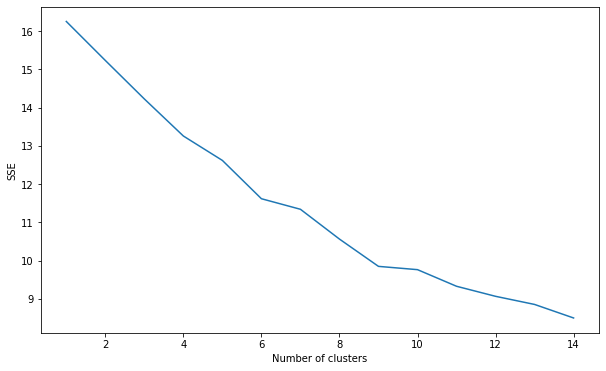

In [133]:
# remove the neighborhood column
toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)

sse = {}
for k in range(1, 15):
    kmeans = KMeans(n_clusters=k, max_iter=1000, random_state=69).fit(toronto_grouped_clustering)
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
plt.figure(figsize=(10, 6))
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of clusters")
plt.ylabel("SSE")
plt.show()

As the elbow is somewhat ambigous here, lets use the silhouette method now.

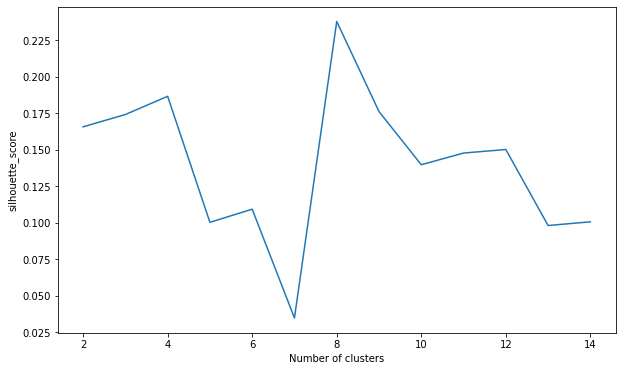

In [134]:
from sklearn.metrics import silhouette_score

sil_coeff = {}

for k in range(2, 15):
    kmeans = KMeans(n_clusters=k, max_iter=1000, random_state=69).fit(toronto_grouped_clustering)
    label = kmeans.labels_
    sil_coeff[k] = silhouette_score(toronto_grouped_clustering, label, metric='euclidean')

plt.figure(figsize=(10, 6))
plt.plot(list(sil_coeff.keys()), list(sil_coeff.values()))
plt.xlabel("Number of clusters")
plt.ylabel("silhouette_score")
plt.show()

We can see that `k=8` has got the highest silhouette_score and also there's an elbow at `k=8` in elbow method. So, we will take **`k=8`** as our number of clusters.

In [166]:
# set number of clusters
kclusters = 8

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=69).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 1, 1, 3, 1, 1, 1, 1, 1, 1], dtype=int32)

Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [0]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

In [168]:
toronto_merged = neigh_df

toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

# remove postal code, we don't need it anymore
toronto_merged.drop('PostalCode', axis=1, inplace=True)

toronto_merged.head()

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,North York,Parkwoods,43.752935,-79.335641,1.0,Construction & Landscaping,Park,Food & Drink Shop,Fireworks Store,Costume Shop,Dog Run,Filipino Restaurant,Convenience Store,Fast Food Restaurant,Farmers Market
1,North York,Victoria Village,43.728102,-79.311890,1.0,Pizza Place,Coffee Shop,Portuguese Restaurant,Intersection,Park,French Restaurant,Dive Bar,Dog Run,Doner Restaurant,Donut Shop
2,Downtown Toronto,"Regent Park, Harbourfront",43.659741,-79.361564,1.0,Coffee Shop,Thai Restaurant,Indian Restaurant,Food Truck,Pub,Sushi Restaurant,Auto Dealership,Pool,Performing Arts Venue,Electronics Store
3,North York,"Lawrence Manor, Lawrence Heights",43.714880,-79.449933,1.0,Fast Food Restaurant,Gas Station,Flower Shop,Furniture / Home Store,Discount Store,Department Store,Restaurant,Bookstore,Coffee Shop,Sandwich Place
4,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.661790,-79.389390,0.0,Coffee Shop,Café,Sushi Restaurant,Yoga Studio,Distribution Center,Pharmacy,Park,Middle Eastern Restaurant,Juice Bar,Italian Restaurant


In [169]:
toronto_merged['Cluster Labels'].value_counts()

1.0    88
5.0     4
0.0     4
3.0     2
2.0     1
4.0     1
7.0     1
6.0     1
Name: Cluster Labels, dtype: int64

Drop any row having NaN values.

In [0]:
toronto_merged.dropna(inplace=True)

In [171]:
toronto_merged['Cluster Labels'].isnull().any()

False

Finally, let's visualize the resulting clusters.

In [0]:
import matplotlib.cm as cm
import matplotlib.colors as colors

In [174]:
cluster_map = folium.Map(location=[toronto_lat, toronto_long], zoom_start=10.5)

kclusters = 8
colors_array = cm.rainbow(np.linspace(0, 1, kclusters))
rainbow = [colors.rgb2hex(i) for i in colors_array]

for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    cluster = int(cluster)
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(cluster_map)

# limit height of scrollable output window
from IPython.display import Javascript
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 650})'''))

cluster_map

<IPython.core.display.Javascript object>

To avoid congestion, lets clusterize the labels.

In [175]:
cluster_map = folium.Map(location=[toronto_lat, toronto_long], zoom_start=10.5)

# instantiate a marker cluster object for the venues in the dataframe
clusters = plugins.MarkerCluster().add_to(cluster_map)

kclusters = 8
colors_array = cm.rainbow(np.linspace(0, 1, kclusters))
rainbow = [colors.rgb2hex(i) for i in colors_array]

for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    cluster = int(cluster)
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(clusters)

# limit height of scrollable output window
from IPython.display import Javascript
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 650})'''))

cluster_map

<IPython.core.display.Javascript object>

Lets examine some representative neighborhoods from each cluster.

Cluster 1

In [176]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
4,"Queen's Park, Ontario Provincial Government",Coffee Shop,Café,Sushi Restaurant,Yoga Studio,Distribution Center,Pharmacy,Park,Middle Eastern Restaurant,Juice Bar,Italian Restaurant
22,Woburn,Coffee Shop,Korean Restaurant,Yoga Studio,Ethiopian Restaurant,Doner Restaurant,Donut Shop,Eastern European Restaurant,Electronics Store,Event Space,Dive Bar
38,"Kennedy Park, Ionview, East Birchmount Park",Convenience Store,Coffee Shop,Discount Store,Department Store,Chinese Restaurant,Cuban Restaurant,Dog Run,Filipino Restaurant,Fast Food Restaurant,Farmers Market
78,Agincourt,Food Court,Coffee Shop,Yoga Studio,Ethiopian Restaurant,Dog Run,Doner Restaurant,Donut Shop,Eastern European Restaurant,Electronics Store,Event Space


Cluster 2

In [177]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]].head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Parkwoods,Construction & Landscaping,Park,Food & Drink Shop,Fireworks Store,Costume Shop,Dog Run,Filipino Restaurant,Convenience Store,Fast Food Restaurant,Farmers Market
1,Victoria Village,Pizza Place,Coffee Shop,Portuguese Restaurant,Intersection,Park,French Restaurant,Dive Bar,Dog Run,Doner Restaurant,Donut Shop
2,"Regent Park, Harbourfront",Coffee Shop,Thai Restaurant,Indian Restaurant,Food Truck,Pub,Sushi Restaurant,Auto Dealership,Pool,Performing Arts Venue,Electronics Store
3,"Lawrence Manor, Lawrence Heights",Fast Food Restaurant,Gas Station,Flower Shop,Furniture / Home Store,Discount Store,Department Store,Restaurant,Bookstore,Coffee Shop,Sandwich Place
5,Islington Avenue,Pharmacy,Bank,Café,Shopping Mall,Grocery Store,Yoga Studio,Electronics Store,Doner Restaurant,Donut Shop,Eastern European Restaurant


Cluster 3

In [178]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 2, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
85,"Milliken, Agincourt North, Steeles East, L'Amo...",Sushi Restaurant,Pharmacy,Event Space,Dog Run,Doner Restaurant,Donut Shop,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Yoga Studio


Cluster 4

In [179]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 3, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
39,Bayview Village,Construction & Landscaping,Trail,Ethiopian Restaurant,Dog Run,Doner Restaurant,Donut Shop,Eastern European Restaurant,Electronics Store,Event Space,Distribution Center
95,Upper Rouge,Home Service,Trail,Yoga Studio,Ethiopian Restaurant,Dog Run,Doner Restaurant,Donut Shop,Eastern European Restaurant,Electronics Store,Event Space


Cluster 5

In [180]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 4, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
45,"York Mills, Silver Hills",Cafeteria,Yoga Studio,Fish & Chips Shop,Filipino Restaurant,Fast Food Restaurant,Farmers Market,Farm,Falafel Restaurant,Event Space,Ethiopian Restaurant


Cluster 6

In [182]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 5, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
26,Cedarbrae,Park,Playground,Flower Shop,Grocery Store,Farm,Falafel Restaurant,Event Space,Ethiopian Restaurant,Discount Store,Electronics Store
57,"Humberlea, Emery",Playground,Park,Discount Store,Fast Food Restaurant,Farmers Market,Farm,Falafel Restaurant,Event Space,Ethiopian Restaurant,Electronics Store
59,Willowdale,Playground,Hotel,Ethiopian Restaurant,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Eastern European Restaurant,Electronics Store,Event Space
72,Willowdale,Playground,Hotel,Ethiopian Restaurant,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Eastern European Restaurant,Electronics Store,Event Space


Cluster 7

In [183]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 6, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
12,"Rouge Hill, Port Union, Highland Creek",Golf Course,Yoga Studio,Distribution Center,Filipino Restaurant,Fast Food Restaurant,Farmers Market,Farm,Falafel Restaurant,Event Space,Ethiopian Restaurant


Cluster 8

In [184]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 7, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
35,East Toronto,Music Venue,Yoga Studio,Fish & Chips Shop,Filipino Restaurant,Fast Food Restaurant,Farmers Market,Farm,Falafel Restaurant,Event Space,Ethiopian Restaurant
